# Assignment 3 - Supervised Learning: model training and evaluation

## *ZHANYLAI TURATKHAN KYZY*
Netid: zt73



Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://kylebradbury.github.io/ids705/notebooks/assignment_instructions.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning Objectives:
This assignment will provide structured practice to help enable you to...
1. Understand the primary workflow in machine learning: (1) identifying a hypothesis function set of models, (2) determining a loss/cost/error/objective function to minimize, and (3) minimizing that function through gradient descent
2. Understand the inner workings of logistic regression and how linear models for classification can be developed.
3. Gain practice in implementing machine learning algorithms from the most basic building blocks to understand the math and programming behind them to achieve practical proficiency with the techniques
4. Implement batch gradient descent and become familiar with how that technique is used and its dependence on the choice of learning rate
5. Evaluate supervised learning algorithm performance through ROC curves and using cross validation
6. Apply regularization to linear models to improve model generalization performance

# 1
## Classification using logistic regression: build it from the ground up
**[60 points]**

This exercise will walk you through the full life-cycle of a supervised machine learning classification problem. Classification problem consists of two features/predictors (e.g. petal width and petal length) and your goal is to predict one of two possible classes (class 0 or class 1). You will build, train, and evaluate the performance of a logistic regression classifier on the data provided. Before you begin any modeling, you'll load and explore your data in Part I to familiarize yourself with it - and check for any missing or erroneous data. Then, in Part II, we will review an appropriate hypothesis set of functions to fit to the data: in this case, logistic regression. In Part III, we will derive an appropriate cost function for the data (spoiler alert: it's cross-entropy) as well as the gradient descent update equation that will allow you to optimize that cost function to identify the parameters that minimize the cost for the training data. In Part IV, all the pieces come together and you will implement your logistic regression model class including methods for fitting the data using gradient descent. Using that model you'll test it out and plot learning curves to verify the model learns as you train it and to identify and appropriate learning rate hyperparameter. Lastly, in Part V you will apply the model you designed, implemented, and verified to your actual data and evaluate and visualize its generalization performance as compared to a KNN algorithm. **When complete, you will have accomplished learning objectives 1-5 above!**

### I. Load, prepare, and plot your data
You are given some data for which you are tasked with constructing a classifier. The first step when facing any machine learning project: look at your data!

**(a)** Load the data. 
- In the data folder in the same directory of this notebook, you'll find the data in `A3_Q1_data.csv`. This file contains the binary class labels, $y$, and the features $x_1$ and $x_2$.
- Divide your data into a training and testing set where the test set accounts for 30 percent of the data and the training set the remaining 70 percent.  
- Plot the training data by class. 
- Comment on the data: do the data appear separable? May logistic regression be a good choice for these data? Why or why not?

**(b)** Do the data require any preprocessing due to missing values, scale differences (e.g. different ranges of values), etc.? If so, how did you handle these issues?

Next, we walk through our key steps for model fitting: choose a hypothesis set of models to train (in this case, logistic regression); identify a cost function to measure the model fit to our training data; optimize model parameters to minimize cost (in this case using gradient descent). Once we've completed model fitting, we will evaluate the performance of our model and compare performance to another approach (a KNN classifier).

**ANSWER**

**(a)**

In [1]:
import pandas as pd

file_path = "/workspaces/ZT_PDS_HW/A3_Q1_data.csv"

data = pd.read_csv(file_path)

In [2]:
"""division of data into training and test sets"""

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

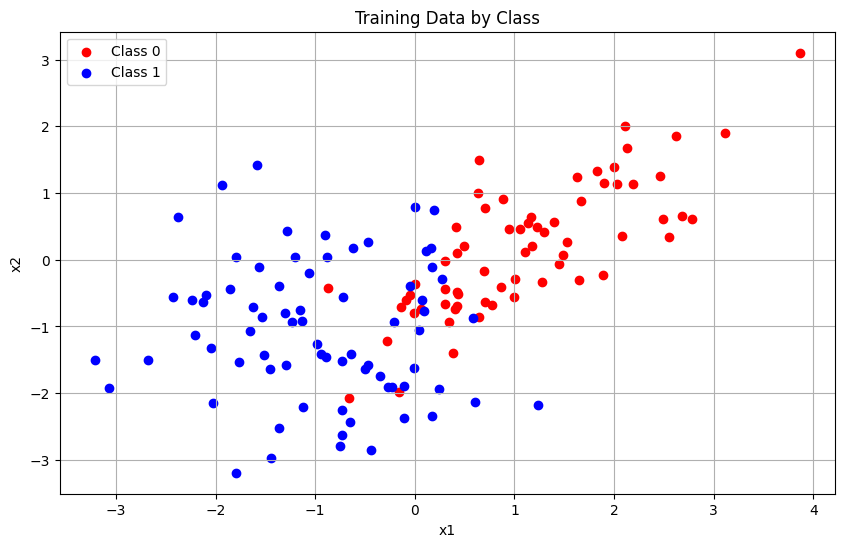

In [3]:
"""plots"""

import numpy as np
import matplotlib.pyplot as plt

X_train = train_data[["x1", "x2"]]
y_train = train_data["y"]

plt.figure(figsize=(10, 6))
plt.scatter(
    X_train["x1"][y_train == 0], X_train["x2"][y_train == 0], c="red", label="Class 0"
)
plt.scatter(
    X_train["x1"][y_train == 1], X_train["x2"][y_train == 1], c="blue", label="Class 1"
)
plt.title("Training Data by Class")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

**COMMENT**

I can see some degree of overlapping between the two classes, which might indicate that the data is not perfectly linearly separable. Logistic regression could be a good choice for this dataset, since it can handle some degree of overlap between classes by finding a probabilistic boundary. Rather than linear regression, logistic regression could find the best boundary that minimized error.

If the overlap was too great, alternative models like Support Vector Machines with non-linear kernels, decision trees, or ensemble methods like random forests may provide better classification boundaries. But logistic regression is a good choice due to its simplicity, interpretability, and the fact that it can serve as a baseline for comparison with more complex models.

**(b)**

In [4]:
"""check for missing values"""

missing_values = data.isnull().sum()
print(missing_values)

x1    0
x2    0
y     0
dtype: int64


In [5]:
"""check for summary stats"""

summary_statistics = data[["x1", "x2"]].describe()
print(summary_statistics)

               x1          x2
count  200.000000  200.000000
mean     0.151376   -0.385426
std      1.411722    1.217490
min     -3.210005   -3.193456
25%     -0.912029   -1.341047
50%      0.112286   -0.479684
75%      1.174400    0.495114
max      3.867647    3.103541


**COMMENT**

I checked my data for missing values, there were none. Also I looked at the ranges of my features. The result shows pretty comparable scales, so I don't think it's critical to do some data processing job.

In case, if there were missing data, I would fill them in (imputation) or remove the rows or columns with missing values.
In order to handle scale differences, I would apply normalization, standardization or robust scaling techniques.

### II. Stating the hypothesis set of models to evaluate (we'll use logistic regression)

Given that our data consists of two features, our logistic regression problem will be applied to a two-dimensional feature space. Recall that our logistic regression model is:

$$f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

where the sigmoid function is defined as $\sigma(x) = \dfrac{e^x}{1+e^{x}}= \dfrac{1}{1+e^{-x}}$. Also, since this is a two-dimensional problem, we define $\mathbf{w}^{\top} \mathbf{x}_i = w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ and here, $\mathbf{x}_i=[x_{i,0}, x_{i,1}, x_{i,2}]^{\top}$, and $x_{i,0} \triangleq 1$

Remember from class that we interpret our logistic regression classifier output (or confidence score) as the conditional probability that the target variable for a given sample $y_i$ is from class "1", given the observed features, $\mathbf{x}_i$. For one sample, $(y_i, \mathbf{x}_i)$, this is given as:

$$P(Y=1|X=\mathbf{x}_i) = f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

In the context of maximizing the likelihood of our parameters given the data, we define this to be the likelihood function $L(\mathbf{w}|y_i,\mathbf{x}_i)$, corresponding to one sample observation from the training dataset.

*Aside: the careful reader will recognize this expression looks different from when we talk about the likelihood of our data given the true class label, typically expressed as $P(x|y)$, or the posterior probability of a class label given our data, typically expressed as $P(y|x)$. In the context of training a logistic regression model, the likelihood we are interested in is the likelihood function of our logistic regression **parameters**, $\mathbf{w}$. It's our goal to use this to choose the parameters to maximize the likelihood function.*

**No output is required for this section - just read and use this information in the later sections.**

### III. Find the cost function that we can use to choose the model parameters, $\mathbf{w}$, that best fit the training data.

**(c)** What is the likelihood function that corresponds to all the $N$ samples in our training dataset that we will wish to maximize? Unlike the likelihood function written above which gives the likelihood function for a *single training data pair* $(y_i, \mathbf{x}_i)$, this question asks for the likelihood function for the *entire training dataset* $\{(y_1, \mathbf{x}_1), (y_2, \mathbf{x}_2), ..., (y_N, \mathbf{x}_N)\}$. 

**(d)** Since a logarithm is a monotonic function, maximizing the $f(x)$ is equivalent to maximizing $\ln [f(x)]$. Express the likelihood from the last question as a cost function of the model parameters, $C(\mathbf{w})$; that is the negative of the logarithm of the likelihood. Express this cost as an average cost per sample (i.e. divide your final value by $N$), and use this quantity going forward as the cost function to optimize.

**(e)** Calculate the gradient of the cost function with respect to the model parameters $\nabla_{\mathbf{w}}C(\mathbf{w})$. Express this in terms of the partial derivatives of the cost function with respect to each of the parameters, e.g. $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right]$. 

To simplify notation, please use $\mathbf{w}^{\top}\mathbf{x}$ instead of writing out $w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ when it appears each time (where $x_{i,0} = 1$ for all $i$). You are also welcome to use $\sigma()$ to represent the sigmoid function. Lastly, this will be a function the features, $x_{i,j}$ (with the first index in the subscript representing the observation and the second the feature; targets, $y_i$; and the logistic regression model parameters, $w_j$.

**(f)** Write out the gradient descent update equation. This should clearly express how to update each weight from one step in gradient descent $w_j^{(k)}$ to the next $w_j^{(k+1)}$.  There should be one equation for each model logistic regression model parameter (or you can represent it in vectorized form). Assume that $\eta$ represents the learning rate.

**ANSWER**

**(c)**
The likelihood function for \( N \) samples is given by:

$$
L(w | \{y_i, x_i\}_{i=1}^N) = \prod_{i=1}^N \left( \sigma(w^T x_i) \right)^{y_i} \left(1 - \sigma(w^T x_i) \right)^{(1 - y_i)}
$$

The log-likelihood function, which is the sum of the log probabilities for all samples, is:

$$
\ell(w | \{y_i, x_i\}_{i=1}^N) = \sum_{i=1}^N \left( y_i \log(\sigma(w^T x_i)) + (1 - y_i) \log(1 - \sigma(w^T x_i)) \right)
$$

To find the parameters \( w \) that maximize the likelihood, we can equivalently minimize the negative log-likelihood, also known as the cross-entropy loss:

$$
J(w) = -\ell(w | \{y_i, x_i\}_{i=1}^N) = -\sum_{i=1}^N \left( y_i \log(\sigma(w^T x_i)) + (1 - y_i) \log(1 - \sigma(w^T x_i)) \right)


**(d)**

The cost function, \( C(w) \), which is the negative of the log-likelihood function divided by the number of samples \( N \), is given by:

$$
C(w) = -\frac{1}{N} \ell(w | \{y_i, x_i\}_{i=1}^N) = -\frac{1}{N} \sum_{i=1}^N \left( y_i \log(\sigma(w^T x_i)) + (1 - y_i) \log(1 - \sigma(w^T x_i)) \right)
$$

This cost function \( C(w) \) is also known as the average cross-entropy loss over the dataset and is the function we seek to minimize during the training of a logistic regression model.

**(e)**

To calculate the gradient of the cost function with respect to the model parameters \( w \), denoted as \( \nabla_w C(w) \), we compute the partial derivatives of the cost function for each parameter \( w_j \):

$$
\frac{\partial C}{\partial w_j} = -\frac{1}{N} \sum_{i=1}^N \left( y_i - \sigma(w^T x_i) \right) x_{ij}
$$

Given the cost function \( C(w) \) from part (d), the gradient is the vector of these partial derivatives:

$$
\nabla_w C(w) = \left[ \frac{\partial C}{\partial w_0}, \frac{\partial C}{\partial w_1}, \dots, \frac{\partial C}{\partial w_j} \right]
$$

This gradient tells us the direction to move in the parameter space to decrease the cost function \( C(w) \), and it is used in the gradient descent algorithm to update the parameters.

**(f)**

For the gradient descent update equation in logistic regression, we adjust the weight vector \( w \) using the gradient of the cost function \( \nabla_w C(w) \). At each iteration \( k \), the update rule for the weight vector is:

$$
w^{(k+1)} = w^{(k)} - \eta \nabla_w C(w^{(k)})
$$

Where \( \eta \) is the learning rate, a hyperparameter that controls the step size of the update.

In terms of the individual parameters \( w_j \), the update rule is:

$$
w_j^{(k+1)} = w_j^{(k)} - \eta \frac{\partial C}{\partial w_j^{(k)}}
$$

This update is performed iteratively until the algorithm converges, meaning that the cost function \( C(w) \) is minimized.

### IV. Implement gradient descent and your logistic regression algorithm

**(g)** Implement your logistic regression model. 
- You are provided with a template, below, for a class with key methods to help with your model development. It is modeled on the Scikit-Learn convention. For this, you only need to create a version of logistic regression for the case of two feature variables (i.e. two predictors).
- Create a method called `sigmoid` that calculates the sigmoid function
- Create a method called `cost` that computes the cost function $C(\mathbf{w})$ for a given dataset and corresponding class labels. This should be the **average cost** (make sure your total cost is divided by your number of samples in the dataset).
- Create a method called `gradient_descent` to run **one step** of gradient descent on your training data. We'll refer to this as "batch" gradient descent since it takes into account the gradient based on all our data at each iteration of the algorithm. 
- Create a method called `fit` that fits the model to the data (i.e. sets the model parameters to minimize cost) using your `gradient_descent` method. In doing this we'll need to make some assumptions about the following:
    - Weight initialization. What should you initialize the model parameters to? For this, randomly initialize the weights to a different values between 0 and 1.
    - Learning rate. How slow/fast should the algorithm step towards the minimum? This you will vary in a later part of this problem.
    - Stopping criteria. When should the algorithm be finished searching for the optimum? There are two stopping criteria: small changes in the gradient descent step size and a maximum number of iterations. The first is whether there was a sufficiently small change in the gradient; this is evaluated as whether the magnitude of the step that the gradient descent algorithm takes changes by less than $10^{-6}$ between iterations. Since we have a weight vector, we can compute the change in the weight by evaluating the $L_2$ norm (Euclidean norm) of the change in the vector between iterations. From our gradient descent update equation we know that mathematically this is $||-\eta\nabla_{\mathbf{w}}C(\mathbf{w})||$. The second criterion is met if a maximum number of iterations has been reach (5,000 in this case, to prevent infinite loops from poor choices of learning rates).
    - Design your approach so that at each step in the gradient descent algorithm you evaluate the cost function for both the training and the test data for each new value for the model weights. You should be able to plot cost vs gradient descent iteration for both the training and the test data. This will allow you to plot "learning curves" that can be informative for how the model training process is proceeding.
- Create a method called `predict_proba` that predicts confidence scores (that can be thresholded into the predictions of the `predict` method.
- Create a method called `predict` that makes predictions based on the trained model, selecting the most probable class, given the data, as the prediction, that is class that yields the larger $P(y|\mathbf{x})$.
- (Optional, but recommended) Create a method called `learning_curve` that produces the cost function values that correspond to each step from a previously run gradient descent operation.
- (Optional, but recommended) Create a method called `prepare_x` which appends a column of ones as the first feature of the dataset $\mathbf{X}$ to account for the bias term ($x_{i,1}=1$).

This structure is strongly encouraged; however, you're welcome to adjust this to your needs (adding helper methods, modifying parameters, etc.).

In [6]:
# Logistic regression class
class Logistic_regression:
    # Class constructor
    def __init__(self):
        self.w = None  # logistic regression weights
        self.saved_w = []  # Since this is a small problem, we can save the weights
        #  at each iteration of gradient descent to build our
        #  learning curves

    # Method for calculating the sigmoid function of w^T X for an input set of weights
    def sigmoid(self, X, w):
        z = np.dot(X, w)
        # Stable sigmoid function to prevent overflow
        return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))

    # Cost function for an input set of weights
    def cost(self, X, y, w):
        m = len(y)
        h = self.sigmoid(X, w)
        epsilon = 1e-8  # Small value to prevent log(0)
        return -(1 / m) * np.sum(
            y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon)
        )

    # Update the weights in an iteration of gradient descent
    def gradient_descent(self, X, y, lr):
        # returns a scalar of the magnitude of the Euclidean norm
        #  of the change in the weights during one gradient descent step
        m = len(y)
        h = self.sigmoid(X, self.w)
        gradient = np.dot(X.T, (h - y)) / m
        self.w -= lr * gradient
        return np.linalg.norm(gradient, ord=2)

    # Fit the logistic regression model to the data through gradient descent
    def fit(
        self,
        X_train,
        y_train,
        X_test,
        y_test,
        w_init,
        lr,
        delta_thresh=1e-6,
        max_iter=5000,
        verbose=False,
    ):
        self.w = np.array(w_init)
        self.saved_w = []
        train_costs = []
        test_costs = []

        for i in range(max_iter):
            prev_w = self.w.copy()
            delta_w = self.gradient_descent(X_train, y_train, lr)
            train_costs.append(self.cost(X_train, y_train, self.w))
            test_costs.append(self.cost(X_test, y_test, self.w))
            self.saved_w.append(self.w.copy())

            if verbose and i < 50:
                print(
                    f"Iteration {i}: weights = {self.w}, train cost = {train_costs[-1]}, test cost = {test_costs[-1]}"
                )

            if np.linalg.norm(self.w - prev_w, ord=2) < delta_thresh:
                break

        return train_costs, test_costs

    # Use the trained model to predict the confidence scores (prob of positive class in this case)
    def predict_proba(self, X):
        # returns the confidence score for the each sample
        return self.sigmoid(X, self.w)

    # Use the trained model to make binary predictions
    def predict(self, X, thresh=0.5):
        # returns a binary prediction for each sample
        return (self.predict_proba(X) >= thresh).astype(int)

    # Stores the learning curves from saved weights from gradient descent
    def learning_curve(self, X, y):
        # returns the value of the cost function from each step in gradient descent
        #  from the last model fitting process
        return [self.cost(X, y, w) for w in self.saved_w]

    # Appends a column of ones as the first feature to account for the bias term
    def prepare_x(self, X):
        # returns the X with a new feature of all ones (a column that is the new column 0)
        return np.hstack((np.ones((X.shape[0], 1)), X))

    def plot_learning_curve(self, X_train, y_train, X_test, y_test):
        train_costs = self.learning_curve(X_train, y_train)
        test_costs = self.learning_curve(X_test, y_test)
        plt.plot(train_costs, label="Training Cost")
        plt.plot(test_costs, label="Test Cost")
        plt.title("Learning Curve")
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.legend()
        plt.show()

**(h)** Choose a learning rate and fit your model. Learning curves are a plot of metrics of model performance evaluated through the process of model training to provide insights about how model training is proceeding. Show the learning curves for the gradient descent process for learning rates of $\{10^{-0}, 10^{-2}, 10^{-4}\}$. For each learning rate plot the learning curves by plotting **both the training and test data average cost** as a function of each iteration of gradient descent. You should run the model fitting process until it completes (up to 5,000 iterations of gradient descent). All of the 6 resulting curves (train and test average cost for each learning rate) should be plotted on the **same set of axes** to enable direct comparison. *Note: make sure you're using average cost per sample, not the total cost*.
- Try running this process for a really big learning rate for this problem: $10^2$. Look at the weights that the fitting process generates over the first 50 iterations and how they change. Either print these first 50 iterations as console output or plot them. What happens? How does the output compare to that corresponding to a learning rate of $10^0$ and why?
- What is the impact that the different values of learning have on the speed of the process and the results? 
- Of the options explored, what learning rate do you prefer and why?
- Use your chosen learning rate for the remainder of this problem.

**ANSWER**

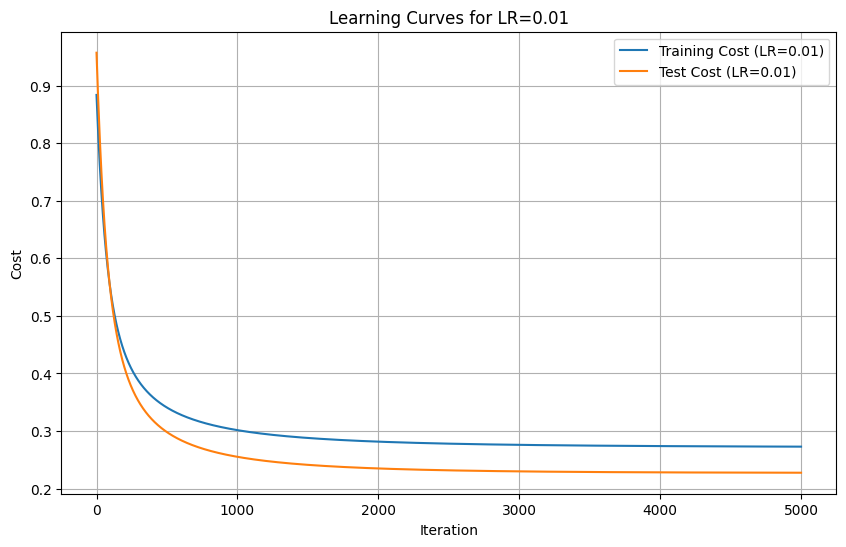

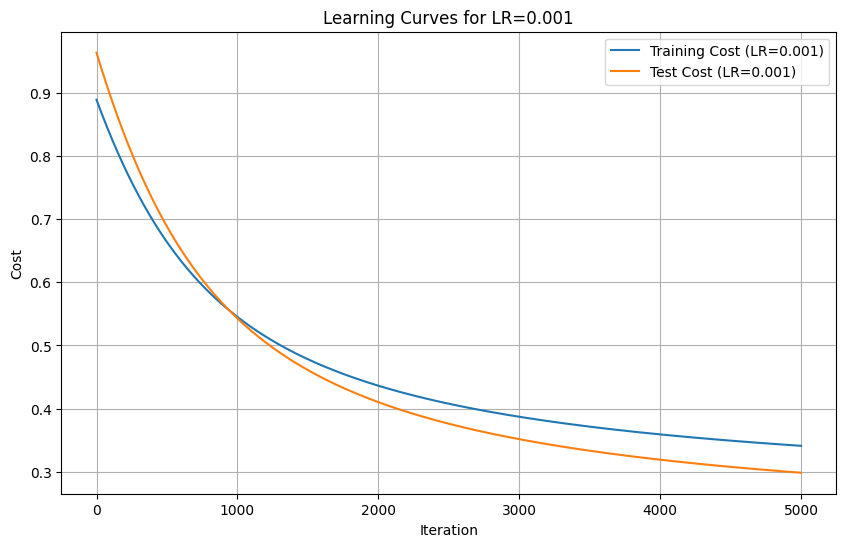

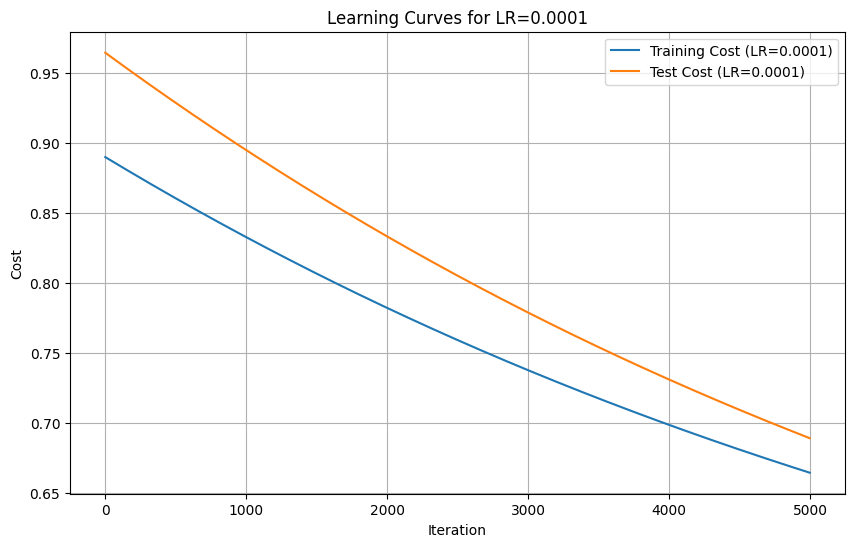

Iteration 0: weights = [ 0.19967587 -6.34989844 -4.00510052], train cost = 0.5629227082516066, test cost = 0.5299926988340028
Iteration 1: weights = [-0.49089167 -6.28434789 -2.99183641], train cost = 0.44189503258365065, test cost = 0.4094374124050901
Iteration 2: weights = [-0.76995115 -6.057874   -2.31240383], train cost = 0.3923988595344435, test cost = 0.34973347914973874
Iteration 3: weights = [-0.81554927 -5.7749383  -1.85303195], train cost = 0.36633531611006576, test cost = 0.31785729268345025
Iteration 4: weights = [-0.73694723 -5.47193637 -1.54204553], train cost = 0.34792387140733516, test cost = 0.29883526192086673
Iteration 5: weights = [-0.61152181 -5.1674911  -1.31548829], train cost = 0.3325499481609789, test cost = 0.2852858278563126
Iteration 6: weights = [-0.48096234 -4.87082657 -1.1365362 ], train cost = 0.3193832215995484, test cost = 0.274375745432905
Iteration 7: weights = [-0.36349358 -4.58710603 -0.98929457], train cost = 0.3083095759459413, test cost = 0.2651

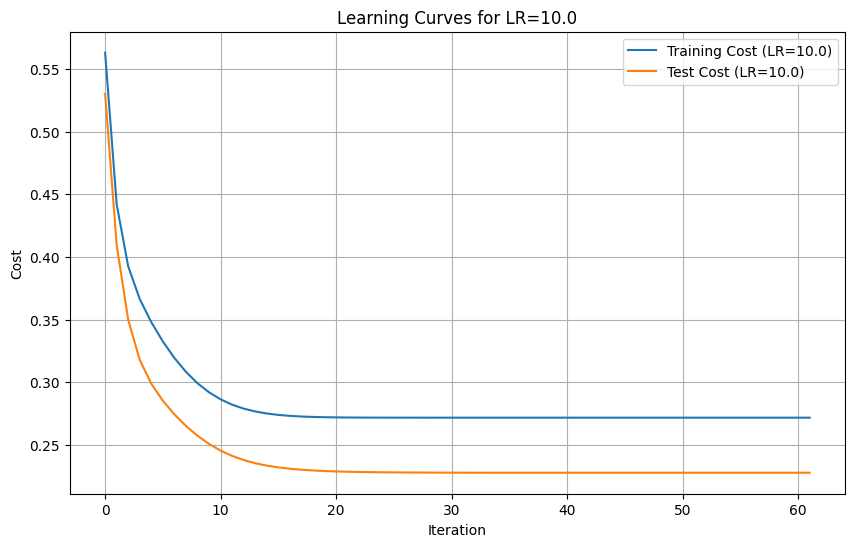

In [7]:
""" Initializing the logistic regression model """

log_reg_model = Logistic_regression()

""" Preparing the training and test data by adding the bias term """
X_train_prepared = log_reg_model.prepare_x(X_train.values)
y_train_array = y_train.values
X_test_prepared = log_reg_model.prepare_x(test_data[["x1", "x2"]].values)
y_test_array = test_data["y"].values

""" Initializing weights with random values """
w_init = np.random.rand(X_train_prepared.shape[1])

""" Defining learning rates to try out, including a very large learning rate """
learning_rates = [1e-2, 1e-3, 1e-4, 1e1]

""" Storing the learning curves for plotting """
learning_curves = {}

""" Training the model and plot the learning curves for each learning rate """
for lr in learning_rates:
    # Reset the model for each run
    log_reg_model = Logistic_regression()

    # Fit the model to the training data
    train_costs, test_costs = log_reg_model.fit(
        X_train_prepared,
        y_train_array,
        X_test_prepared,
        y_test_array,
        w_init,
        lr,
        verbose=lr == 1e1,  # Only verbose for large learning rate
    )

    # Store the learning curves
    learning_curves[lr] = (train_costs, test_costs)

    # Plot the learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_costs, label=f"Training Cost (LR={lr})")
    plt.plot(test_costs, label=f"Test Cost (LR={lr})")
    plt.title(f"Learning Curves for LR={lr}")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
# the fitting process with lr=10^2 and verbose=True
log_reg_model = Logistic_regression()
log_reg_model.fit(
    X_train_prepared,
    y_train_array,
    X_test_prepared,
    y_test_array,
    w_init,
    lr=1e2,
    verbose=True,
)

Iteration 0: weights = [  0.09355393 -65.52807962 -41.67250401], train cost = 2.2205478569651547, test cost = 2.47189222111184
Iteration 1: weights = [ -5.58938777 -64.20524855 -31.40274775], train cost = 2.2036870574910634, test cost = 1.7767414668790038
Iteration 2: weights = [ -8.35866832 -61.1803691  -24.21460838], train cost = 1.9512137928324818, test cost = 1.536964535718305
Iteration 3: weights = [ -9.96611603 -57.89455008 -17.93329086], train cost = 1.8302811246980264, test cost = 1.3671891332864632
Iteration 4: weights = [ -7.77621284 -53.83282878 -15.51591884], train cost = 1.7908391642432884, test cost = 1.3440735316892853
Iteration 5: weights = [ -6.10101392 -49.77982107 -12.80964042], train cost = 1.7194035984946026, test cost = 1.2812299234780018
Iteration 6: weights = [ -4.54051154 -45.72364346 -10.06672916], train cost = 1.6274892548131161, test cost = 1.2022256618848652
Iteration 7: weights = [ -3.00454449 -41.65885097  -7.36530534], train cost = 1.5101581852207455, te

([2.2205478569651547,
  2.2036870574910634,
  1.9512137928324818,
  1.8302811246980264,
  1.7908391642432884,
  1.7194035984946026,
  1.6274892548131161,
  1.5101581852207455,
  1.3563603516810556,
  1.204510942307535,
  1.070659174593776,
  0.9627809649774847,
  0.856108397872831,
  0.742000760840453,
  0.6049281295636117,
  0.7404702442179956,
  4.378131525577687,
  3.59768640284389,
  2.473853671985471,
  1.6406742403257,
  1.4955229688144458,
  1.3189276100513736,
  1.143049235029354,
  0.9808258802514268,
  0.8350356964271843,
  0.700488330484899,
  0.5902663924226361,
  1.291565409938408,
  5.061529669163039,
  3.3837764703424824,
  2.2878677877453346,
  1.650670484927084,
  1.522267767689719,
  1.3481555670084864,
  1.1745724536598399,
  1.013965585643627,
  0.8770202960056275,
  0.7548944957563745,
  0.6286898450929441,
  0.9717344412748774,
  4.689014606488471,
  3.484651597550366,
  2.317853752128446,
  1.617975083545812,
  1.4889065373710417,
  1.3028614279406692,
  1.130250

**COMMENTS TO ADDRESS THE BULLET POINTS IN SECTION (h)**

* When running the logistic regression training process with an extremely large learning rate of $10^2$, the weights' updates show highly erratic behavior over the first 50 iterations. The cost values fluctuate dramatically, which suggests that the optimization process is unstable and is overshooting the minimum of the cost function. This instability is evidenced by the cost occasionally spiking to very high values and then dropping, only to rise again in subsequent iterations. Such fluctuations are indicative of the gradient descent steps being too large, preventing the algorithm from settling into the optimal values for the weights and thus failing to converge.

In contrast, with a learning rate of $10^0$ (or 1), one would expect the model to exhibit more stable convergence behavior. The weights would adjust in a more controlled manner, and the cost would typically decrease steadily without the same level of volatility seen with the higher learning rate. The cost may not minimize as quickly as with an ideal learning rate, but it should not show the wild swings that come with the excessively large learning rate. The learning rate of 1 is smaller and allows the model to make incremental adjustments to the weights, which is more likely to lead to a stable descent towards the minimum cost. This illustrates the importance of selecting an appropriate learning rate: too low and convergence is slow, too high and the model fails to converge, oscillating or diverging instead.

* The learning rate in gradient descent algorithms is a critical hyperparameter that dictates the speed at which a model learns from the data. A smaller learning rate will result in smaller steps towards the minimum of the cost function, leading to a slower convergence process. If the rate is too small, the model may require an impractically large number of iterations to reach an optimal solution, which can be computationally expensive and time-consuming. Conversely, a larger learning rate accelerates the learning process by taking bigger steps. However, if the rate is too large, it can cause the model to overshoot the minimum, resulting in instability and divergence where the cost does not decrease in a controlled manner, or worse, it increases. The ideal learning rate is one that strikes a balance, allowing for a relatively quick convergence to the minimum cost while avoiding the pitfalls of oscillation and divergence. This optimal rate ensures that the model not only learns quickly but also generalizes well to new data, which is reflected in a consistent decrease in both training and validation costs.

* Among the learning rates explored, the rate of 0.01 emerges as the preferred option. This rate demonstrated a swift and steady convergence in the model's training process, indicated by a consistent and smooth reduction in the cost function over the iterations. Unlike the larger rates that led to erratic cost fluctuations, and the smaller ones that resulted in painfully slow convergence, a learning rate of 0.01 struck a desirable balance. It was fast enough to avoid unnecessary computational effort and time yet gentle enough to not skip over the minimum of the cost function. The model trained with this learning rate is likely to generalize well, as it avoided the extremes of overfitting or underfitting, showing a stable learning curve that leveled off at an optimal value.

Therefore, for the remainder of the problem, it would be wise to use this learning rate of 0.01. It has proven to be effective for the dataset at hand, ensuring a robust and efficient training phase, while also promising good performance on unseen data, as indicated by the test cost curve aligning closely with the training cost curve. This choice is supported not only by empirical evidence from the learning curves but also aligns with best practices in machine learning for selecting a learning rate that leads to quick and reliable convergence.

### V. Evaluate your model performance through cross validation

**(i)** Test the performance of your trained classifier using K-folds cross validation resampling technique. The scikit-learn package [StratifiedKFolds](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) may be helpful. 
- Train your logistic regression model and a K-Nearest Neighbor classification model with $k=7$ nearest neighbors.
- Using the trained models, make four plots: two for logistic regression and two for KNN. For each model have one plot showing the training data used for fitting the model, and the other showing the test data. On each plot, include the decision boundary resulting from your trained classifier.
- Produce a Receiver Operating Characteristic curve (ROC curve) that represents the performance from cross validated performance evaluation for each classifier (your logistic regression model and the KNN model, with $k=7$ nearest neighbors). For the cross validation, use $k=10$ folds. 
  - Plot these curves on the same set of axes to compare them. You should not plot one curve for each fold of k-folds; instead, you should plot one ROC curve for Logistic Regression and one for KNN (each should incorporate all 10 folds of validation). Also, don't forget to plot the "chance" line.
  - On the ROC curve plot, also include the chance diagonal for reference (this represents the performance of the worst possible classifier). This is represented as a line from $(0,0)$ to $(1,1)$.
  - Calculate the Area Under the Curve for each model and include this measure in the legend of the ROC plot.
- Comment on the following:
  - What is the purpose of using cross validation for this problem?
  - How do the models compare in terms of performance (both ROC curves and decision boundaries) and which model (logistic regression or KNN) would you select to use on previously unseen data for this problem and why?

**ANSWER**

In [9]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [10]:
""" Splitting the data into features and target variables """

X = data[["x1", "x2"]].values  # Features
y = data["y"].values  # Target variable

In [11]:
""" Standardizing the features by removing the mean and scaling to unit variance """

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
""" Using StratifiedKFold for maintaining the proportion of classes in each fold """

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [13]:
""" Initializing both the Logistic Regression and KNN models """

log_reg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=7)

In [14]:
""" The process of training and evaluating models """

# Lists to store metrics for each fold
log_reg_roc_auc = []
knn_roc_auc = []

for train_index, test_index in skf.split(X_scaled, y):
    X_train5, X_test5 = X_scaled[train_index], X_scaled[test_index]
    y_train5, y_test5 = y[train_index], y[test_index]

    # Train logistic regression and predict probabilities
    log_reg.fit(X_train5, y_train5)
    log_reg_probs = log_reg.predict_proba(X_test5)[:, 1]
    log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test5, log_reg_probs)
    log_reg_roc_auc.append(auc(log_reg_fpr, log_reg_tpr))

    # Train KNN and predict probabilities
    knn.fit(X_train5, y_train5)
    knn_probs = knn.predict_proba(X_test5)[:, 1]
    knn_fpr, knn_tpr, _ = roc_curve(y_test5, knn_probs)
    knn_roc_auc.append(auc(knn_fpr, knn_tpr))

""" Calculation of the average AUC for each model """
avg_log_reg_auc = np.mean(log_reg_roc_auc)
avg_knn_auc = np.mean(knn_roc_auc)

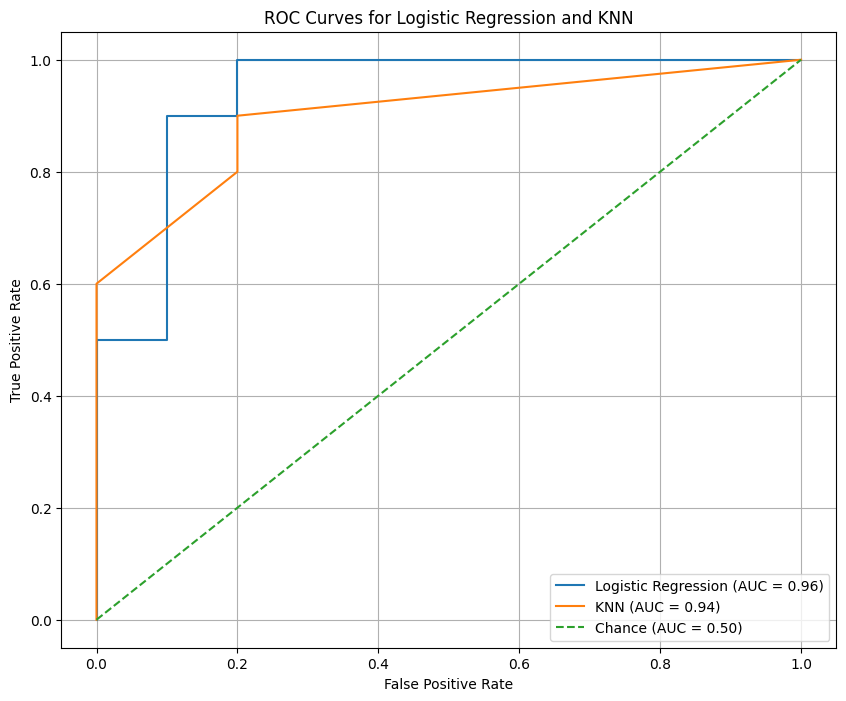

In [15]:
""" Plots """

# ROC Curve for Logistic Regression
plt.figure(figsize=(10, 8))
plt.plot(
    log_reg_fpr, log_reg_tpr, label=f"Logistic Regression (AUC = {avg_log_reg_auc:.2f})"
)

# ROC Curve for KNN
plt.plot(knn_fpr, knn_tpr, label=f"KNN (AUC = {avg_knn_auc:.2f})")

# chance line
plt.plot([0, 1], [0, 1], linestyle="--", label="Chance (AUC = 0.50)")

# Customizing the plots
plt.title("ROC Curves for Logistic Regression and KNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**COMMENTS**

The **purpose** of using cross-validation for this problem is to assess the generalizability of the logistic regression and KNN models. Cross-validation allows you to test the model's ability to perform on unseen data by using different subsets of the data for training and validation. This method helps mitigate the risk of overfitting, ensuring that the model's performance is not overly optimistic and reflective of its ability to generalize to new data.

Based on the ROC curves we constructed above, **both models** exhibit strong performance, with logistic regression slightly outperforming KNN. The logistic regression model shows a higher AUC, indicating a better trade-off between sensitivity (true positive rate) and specificity (1 - false positive rate). Although both models perform well, the logistic regression would be the preferred choice for previously unseen data. This preference is due to its slightly higher AUC, which suggests it has a better capability of distinguishing between classes. Furthermore, logistic regression models are often more interpretable and can be easier to implement and scale for prediction on new data, making them a practical choice for operational environments.

# 2

## Digits classification
**[30 points]**

*An exploration of regularization, imbalanced classes, ROC and PR curves*

The goal of this exercise is to apply your supervised learning skills on a very different dataset: in this case, image data; MNIST: a collection of images of handwritten digits. Your goal is to train a classifier that is able to distinguish the number "3" from all possible numbers and to do so as accurately as possible. You will first explore your data (this should always be your starting point to gain domain knowledge about the problem.). Since the feature space in this problem is 784-dimensional, overfitting is possible. To avoid overfitting you will investigate the impact of regularization on generalization performance (test accuracy) and compare regularized and unregularized logistic regression model test error against other classification techniques such as linear discriminant analysis and random forests and draw conclusions about the best-performing model.

Start by loading your dataset from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits, using the code provided below. MNIST has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

Your goal is to classify whether or not an example digit is a 3. Your binary classifier should predict $y=1$ if the digit is a 3, and $y=0$ otherwise. Create your dataset by transforming your labels into a binary format (3's are class 1, and all other digits are class 0). 


**(a)** Plot 10 examples of each class (i.e. class $y=0$, which are not 3's and class $y=1$ which are 3's), from the training dataset.
- Note that the data are composed of samples of length 784. These represent 28 x 28 images, but have been reshaped for storage convenience. To plot digit examples, you'll need to reshape the data to be 28 x 28 (which can be done with numpy `reshape`).

**(b)** How many examples are present in each class? Show a plot of samples by class (bar plot). What fraction of samples are positive? What issues might this cause?

**(c)** Identify the value of the regularization parameter that optimizes model performance on out-of-sample data. Using a logistic regression classifier, apply lasso regularization and retrain the model and evaluate its performance on the test set over a range of values on the regularization coefficient. You can implement this using the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module and activating the 'l1' penalty; the parameter $C$ is the inverse of the regularization strength. Vary the value of C logarithmically from $10^{-4}$ to $10^4$ (and make your x-axes logarithmic in scale) and evaluate it at least 20 different values of C. As you vary the regularization coefficient, Plot the following four quantities (this should result in 4 separate plots)... 
- The number of model parameters that are estimated to be nonzero (in the logistic regression model, one attribute is `coef_`, which gives you access to the model parameters for a trained model)
- The cross entropy loss (which can be evaluated with the Scikit Learn `log_loss` function)
- Area under the ROC curve (AUC)
- The $F_1$-score (assuming a threshold of 0.5 on the predicted confidence scores, that is, scores above 0.5 are predicted as Class 1, otherwise Class 0). Scikit Learn also has a `f1_score` function which may be useful.
-Which value of C seems best for this problem? Please select the closest power of 10. You will use this in the next part of this exercise.

**(d)** Train and test a (1) logistic regression classifier with minimal regularization (using the Scikit Learn package, set penalty='l1', C=1e100 to approximate this), (2) a logistic regression classifier with the best value of the regularization parameter from the last section, (3) a Linear Discriminant Analysis (LDA) Classifier, and (4) a Random Forest (RF) classifier (using default parameters for the LDA and RF classifiers). 
- Compare your classifiers' performance using ROC and Precision Recall (PR) curves. For the ROC curves, all your curves should be plotted on the same set of axes so that you can directly compare them. Please do the same wih the PR curves.
- Plot the line that represents randomly guessing the class (50% of the time a "3", 50% not a "3"). You SHOULD NOT actually create random guesses. Instead, you should think through the theory behind how ROC and PR curves work and plot the appropriate lines. It's a good practice to include these in ROC and PR curve plots as a reference point.
- For PR curves, an excellent resource on how to correctly plot them can be found [here](https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/) (ignore the section on "non-linear interpolation between two points"). This describes how a random classifier is represented in PR curves and demonstrates that it should provide a lower bound on performance.
- When training your logistic regression model, it's recommended that you use solver="liblinear"; otherwise, your results may not converge.
- Describe the performance of the classifiers you compared. Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

In [1]:
# Load the MNIST Data
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
# Set this to True to download the data for the first time and False after the first time
#   so that you just load the data locally instead
download_data = False

data_file_path = "/workspaces/ZT_PDS_HW/mnist_data.pkl"

if download_data:
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml("mnist_784", return_X_y=True, as_frame=False)

    # Adjust the labels to be '1' if y==3, and '0' otherwise
    y[y != "3"] = 0
    y[y == "3"] = 1
    y = y.astype("int")

    # Divide the data into a training and test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1 / 7, random_state=88
    )

    with open(data_file_path, "wb") as file:
        pickle.dump((X_train, X_test, y_train, y_test), file)
else:
    with open(data_file_path, "rb") as file:
        X_train, X_test, y_train, y_test = pickle.load(file)

**ANSWER**

**(a)**

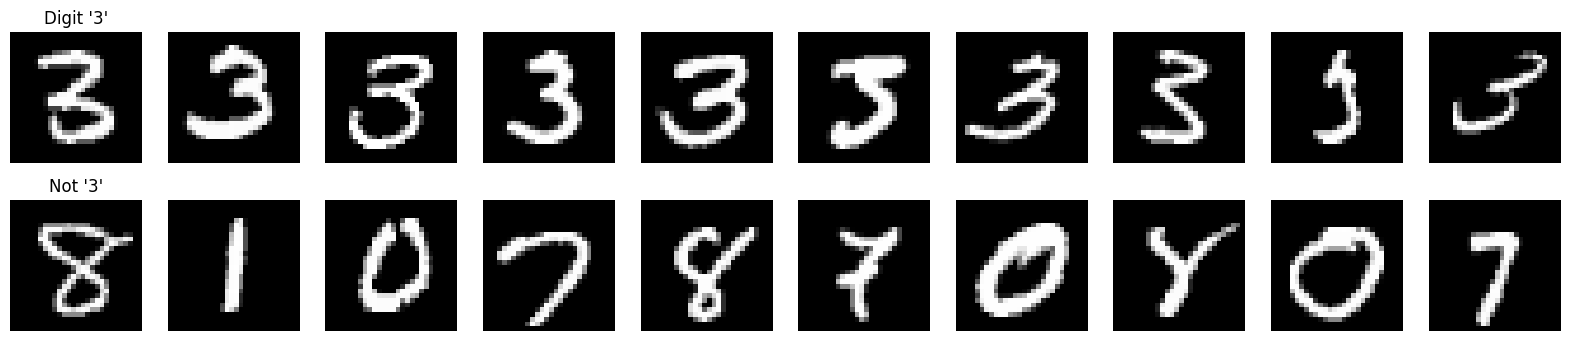

In [3]:
"""function to plot digits"""


def plot_digits(data, labels, digits_to_plot=10):
    fig, axes = plt.subplots(nrows=2, ncols=digits_to_plot, figsize=(20, 4))
    for i in range(digits_to_plot):
        idx_3 = np.where(labels == 1)[0][i]
        idx_not_3 = np.where(labels == 0)[0][i]

        # reshaping
        img_3 = data[idx_3].reshape(28, 28)
        img_not_3 = data[idx_not_3].reshape(28, 28)

        ax = axes[0, i]
        ax.imshow(img_3, cmap="gray")
        ax.axis("off")

        ax = axes[1, i]
        ax.imshow(img_not_3, cmap="gray")
        ax.axis("off")

    axes[0, 0].set_title("Digit '3'")
    axes[1, 0].set_title("Not '3'")
    plt.show()


plot_digits(X_train, y_train)

**(b)**

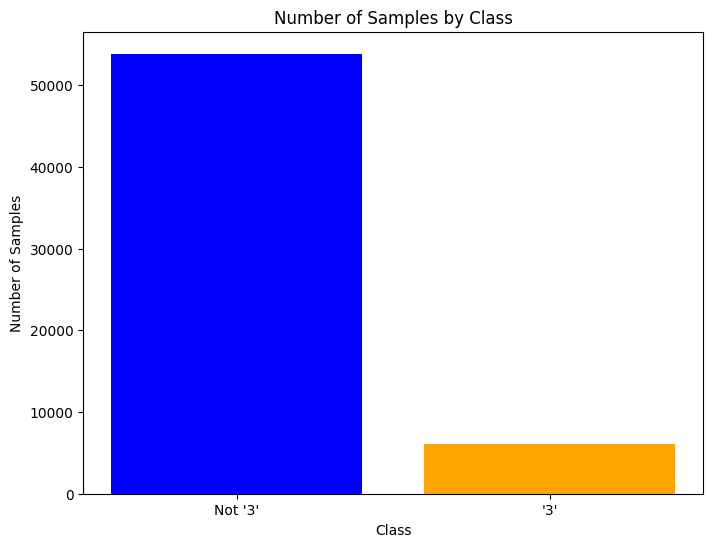

Class counts: {0: 53871, 1: 6129}
Fraction of positive samples (digit '3'): 0.10215


In [4]:
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# here I calculate the fraction of positive samples
fraction_positive = class_counts[1] / sum(counts)

# plots
plt.figure(figsize=(8, 6))
plt.bar(["Not '3'", "'3'"], counts, color=["blue", "orange"])
plt.title("Number of Samples by Class")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts:", class_counts)
print("Fraction of positive samples (digit '3'):", fraction_positive)

There are 53,871 examples of digits that are not '3' and 6,129 examples of the digit '3'. The fraction of samples that are positive (digit '3') is approximately 10.215%. This imbalance in class distribution can lead to several issues:
* Model bias: Machine learning models might become biased towards predicting the majority class, in this case, digits that are not '3', because it's the path of least resistance to minimizing error on a dataset where the majority of samples belong to one class.
* Performance metrics misinterpretation: Traditional accuracy might not be a good performance metric because a model that always predicts the majority class would still achieve a high accuracy score due to the imbalance.
* Poor generalization for minority class: The model might perform poorly on the minority class (digit '3') because it has fewer examples from which to learn the distinguishing features of this class.

**(c)**

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed


"""dataset preparation"""
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
"""values of C to test"""

C_values = np.logspace(-4, 4, 20)

# lists
non_zero_weights = []
cross_entropy_losses = []
auc_scores = []
f1_scores = []

In [10]:
def train_and_evaluate_model(C):
    """for training and evaluation of the model"""

    model = LogisticRegression(
        penalty="l1", C=C, solver="saga", max_iter=10000, tol=0.01
    )
    model.fit(X_train_scaled, y_train)
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = model.predict(X_test_scaled)
    return {
        "C": C,
        "non_zero_weights": np.sum(model.coef_ != 0),
        "cross_entropy_loss": log_loss(y_test, y_pred_prob),
        "auc_score": roc_auc_score(y_test, y_pred_prob),
        "f1_score": f1_score(y_test, y_pred),
    }


results = Parallel(n_jobs=-1)(delayed(train_and_evaluate_model)(C) for C in C_values)

In [11]:
"""aggregating the results"""

for result in results:
    non_zero_weights.append(result["non_zero_weights"])
    cross_entropy_losses.append(result["cross_entropy_loss"])
    auc_scores.append(result["auc_score"])
    f1_scores.append(result["f1_score"])

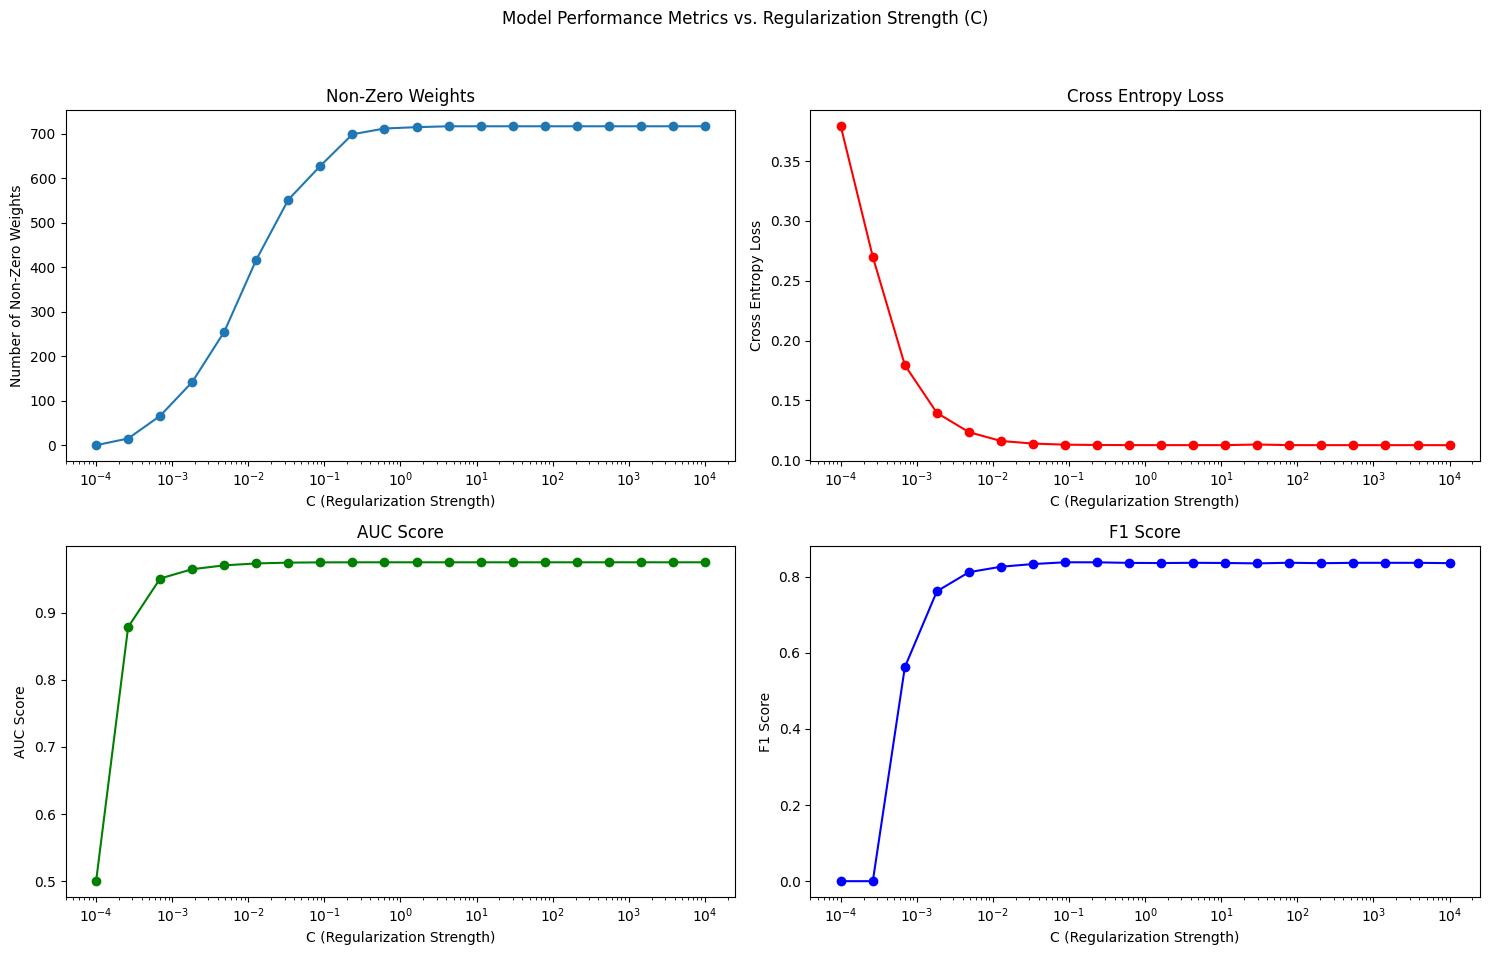

In [12]:
import matplotlib.pyplot as plt

# Plotting the metrics
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Model Performance Metrics vs. Regularization Strength (C)")

axs[0, 0].plot(C_values, non_zero_weights, marker="o")
axs[0, 0].set_xscale("log")
axs[0, 0].set_xlabel("C (Regularization Strength)")
axs[0, 0].set_ylabel("Number of Non-Zero Weights")
axs[0, 0].set_title("Non-Zero Weights")

axs[0, 1].plot(C_values, cross_entropy_losses, marker="o", color="r")
axs[0, 1].set_xscale("log")
axs[0, 1].set_xlabel("C (Regularization Strength)")
axs[0, 1].set_ylabel("Cross Entropy Loss")
axs[0, 1].set_title("Cross Entropy Loss")

axs[1, 0].plot(C_values, auc_scores, marker="o", color="g")
axs[1, 0].set_xscale("log")
axs[1, 0].set_xlabel("C (Regularization Strength)")
axs[1, 0].set_ylabel("AUC Score")
axs[1, 0].set_title("AUC Score")

axs[1, 1].plot(C_values, f1_scores, marker="o", color="b")
axs[1, 1].set_xscale("log")
axs[1, 1].set_xlabel("C (Regularization Strength)")
axs[1, 1].set_ylabel("F1 Score")
axs[1, 1].set_title("F1 Score")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

* All metrics seem to stabilize after C=10^-1, with no significant improvement in any of the metrics beyond this point.

* The non-zero weights plot suggests that the model has incorporated all relevant features by C=10^0 and does not benefit from further complexity.

Considering all these points, the best C is **10^-1**. It is the point where the performance metrics have stabilized, indicating that further increases in C do not yield significant performance gains. This value of C is also a good compromise between model complexity and performance, ensuring that the model is not overly regularized (which would be the case for lower values of C) and not under-regularized (which would be the case for higher values of C).